### Chapter 4 Select Applied Solutions

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

from ISLP import confusion_table
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

**Problem 13**

In [4]:
Weekly = load_data("Weekly")
Weekly.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

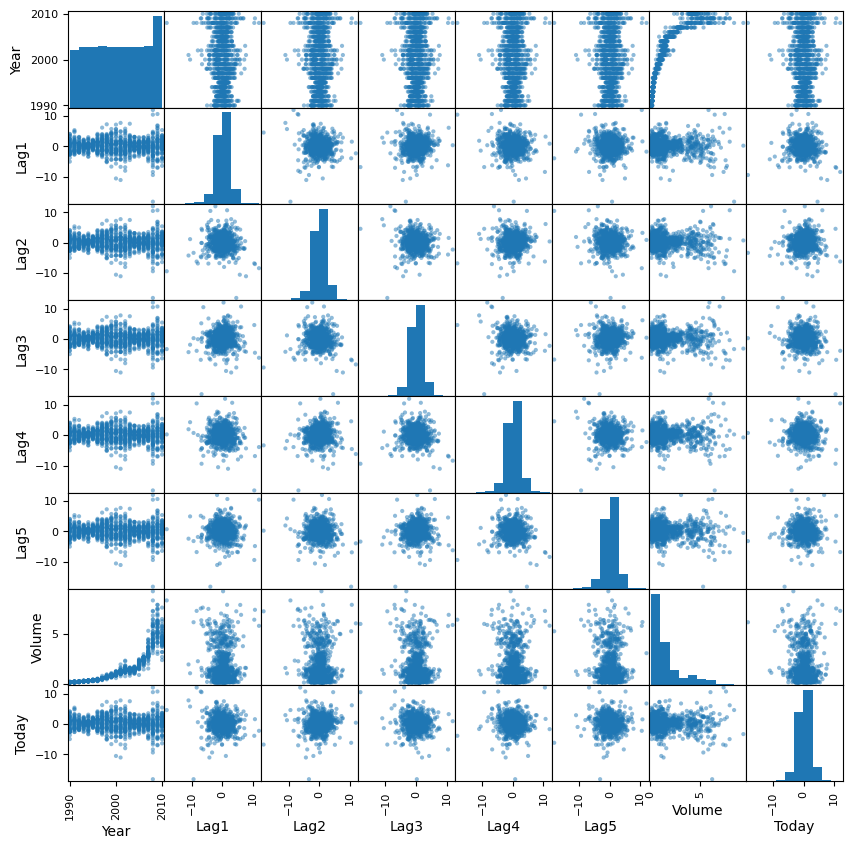

In [148]:
pd.plotting.scatter_matrix(Weekly, figsize =(10,10));


In [6]:
Weekly.corr(numeric_only = True).round(4).style.background_gradient(cmap = 'coolwarm')

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032300,-0.033400,-0.030000,-0.031100,-0.030500,0.841900,-0.032500
Lag1,-0.032300,1.000000,-0.074900,0.058600,-0.071300,-0.008200,-0.065000,-0.075000
Lag2,-0.033400,-0.074900,1.000000,-0.075700,0.058400,-0.072500,-0.085500,0.059200
Lag3,-0.030000,0.058600,-0.075700,1.000000,-0.075400,0.060700,-0.069300,-0.071200
Lag4,-0.031100,-0.071300,0.058400,-0.075400,1.000000,-0.075700,-0.061100,-0.007800
Lag5,-0.030500,-0.008200,-0.072500,0.060700,-0.075700,1.000000,-0.058500,0.011000
Volume,0.841900,-0.065000,-0.085500,-0.069300,-0.061100,-0.058500,1.000000,-0.033100
Today,-0.032500,-0.075000,0.059200,-0.071200,-0.007800,0.011000,-0.033100,1.000000


In [12]:
all_vars = Weekly.columns.drop(["Direction", "Year", "Today"])
design = MS(all_vars)
X = design.fit_transform(Weekly)
Y = Weekly.Direction =="Up"
glm = sm.GLM(Y, X, family = sm.families.Binomial())
summarize(glm.fit())

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


Only the Lag 2 is statitically significant in its coefficient all others are not ststaistically significant 

In [18]:
results = glm.fit()
probs = results.predict() 
labels = np.array(['Down']*1089)
labels[probs>0.5] = "Up"

confusion_table(labels, Weekly.Direction)


Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [ ]:
Sensitivity = np.mean(labels[Weekly.Direction == "Up"] == "Up")
Specificity = np.mean(labels[Weekly.Direction == "Down"] == "Down")
np.mean(labels == Weekly.Direction), Sensitivity, Specificity


(0.5610651974288338, 0.9206611570247933, 0.1115702479338843)

Correct prediction would be 557 + 54 = 611, fraction of overall correct predictions on the training data would be 56%. Confusion matrix tells us about the sensittivity and specififcity. In this case the ability to correctly identify when the market is up is (92%) while the ability to correctly say when the markey will be down is (11%). So better to put money in on the days it says it'll be up rather than taking money out when it says the makret will be down.


In [122]:
train = (Weekly.Year < 2009) 

## adding the [Lag2] only picks Lag2 as the predictor, could also add multiple predictors

X_train, X_test = Weekly.loc[train][['Lag2']], Weekly.loc[~train][['Lag2']]
y_train, y_test = Y.loc[train], Y.loc[~train]
X_train


,Lag2
0,1.572
1,0.816
2,-0.270
3,-2.576
4,3.514
...,...
980,-8.389
981,12.026
982,-2.251
983,0.418


In [123]:
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)


In [124]:
labels = np.array(['Down']*104)
labels[probs>0.5] = "Up"
D = Weekly.Direction

L_train, L_test = D.loc[train], D.loc[~train]
Model_Compare = pd.DataFrame({"Model": ["Logistic Regression"], 
                               'Test Accuracy': [np.mean(labels == L_test)], 
                               'Test Error': [np.mean(labels != L_test)]})
Model_Compare.set_index("Model", inplace = True)
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,20,24
Up,23,37


In [125]:
Model_Compare

,Test Accuracy,Test Error
Model,,
Logistic Regression,0.548077,0.451923


In [126]:
lda = LDA(store_covariance=True)

lda.fit(X_train, y_train)
lda_pred = lda.predict(X_test)

labels = np.array(["Down"]*104)
labels[lda_pred>0.5] = "Up"

LDA_row = pd.DataFrame([{'Test Accuracy': np.mean(labels == L_test), 
           'Test Error': np.mean(labels != L_test)}], index = ["LDA"])
Model_Compare = pd.concat([Model_Compare, LDA_row])


confusion_table(labels, L_test)


Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [127]:
qda = QDA(store_covariance=True)

qda.fit(X_train, y_train)
qda_pred = qda.predict(X_test)

labels = np.array(["Down"]*104)
labels[qda_pred>0.5] = "Up"

QDA_row = pd.DataFrame([{'Test Accuracy': np.mean(labels == L_test), 
           'Test Error': np.mean(labels != L_test)}], index = ["QDA"])
Model_Compare = pd.concat([Model_Compare, QDA_row])


confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [128]:
knn1 = KNeighborsClassifier(n_neighbors=1)

knn1.fit(X_train, y_train)
knn1_pred = knn1.predict(X_test)

labels = np.array(["Down"]*104)
labels[knn1_pred>0.5] = "Up"

KNN_row = pd.DataFrame([{'Test Accuracy': np.mean(labels == L_test), 
           'Test Error': np.mean(labels != L_test)}], index = ["KNN"])
Model_Compare = pd.concat([Model_Compare, KNN_row])


confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,22,31
Up,21,30


In [129]:
NB = GaussianNB()
NB.fit(X_train, L_train)

NB_pred = NB.predict(X_test)

NB_row = pd.DataFrame([{'Test Accuracy': np.mean(NB_pred == L_test), 
           'Test Error': np.mean(NB_pred != L_test)}], index = ["NB"])
Model_Compare = pd.concat([Model_Compare, NB_row])


confusion_table(NB_pred, L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [130]:
Model_Compare

,Test Accuracy,Test Error
Logistic Regression,0.548077,0.451923
LDA,0.625000,0.375000
QDA,0.586538,0.413462
KNN,0.500000,0.500000
NB,0.586538,0.413462


<Axes: title={'center': 'KNN Test Accuracy and Error'}, xlabel='k', ylabel='Test Accuracy/Error'>

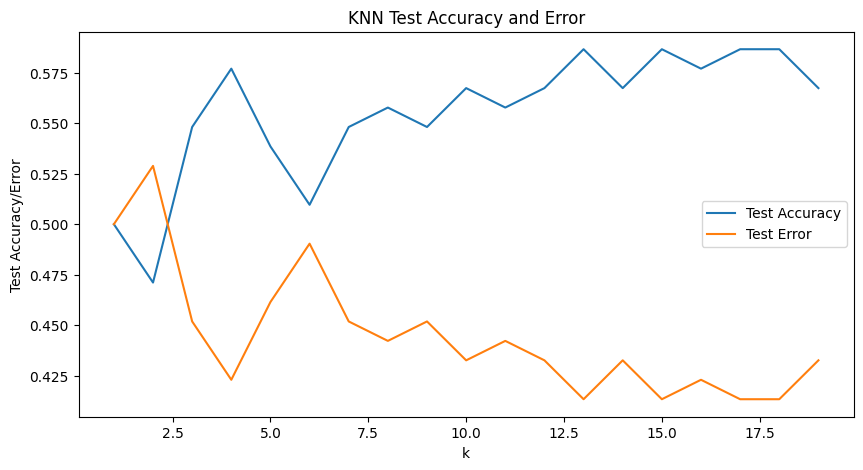

In [ ]:
results = []

for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)

    labels = np.array(["Down"]*104)
    labels[knn_pred>0.5] = "Up"

    acc = np.mean(labels == L_test)
    err = np.mean(labels != L_test)

    results.append({'k': i, 'Test Accuracy': acc, 'Test Error': err})

KNN_Compare = pd.DataFrame(results).set_index('k')


KNN_Compare.plot(
    title="KNN Test Accuracy and Error",
    xlabel="k",
    ylabel="Test Accuracy/Error",
    figsize=(10, 5)
)   

**Problem 14**


In [161]:
Auto = load_data("Auto")
mpg01 = []

for i in range(len(Auto)):
    if Auto.mpg.iloc[i] > Auto.mpg.median():
        mpg01.append(1)
    else:
        mpg01.append(0)

Auto['mpg01'] = mpg01
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
name,,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1,0
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1,0
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1,0
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1,0
ford torino,17.0,8,302.0,140,3449,10.5,70,1,0
...,...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2,1
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1,1


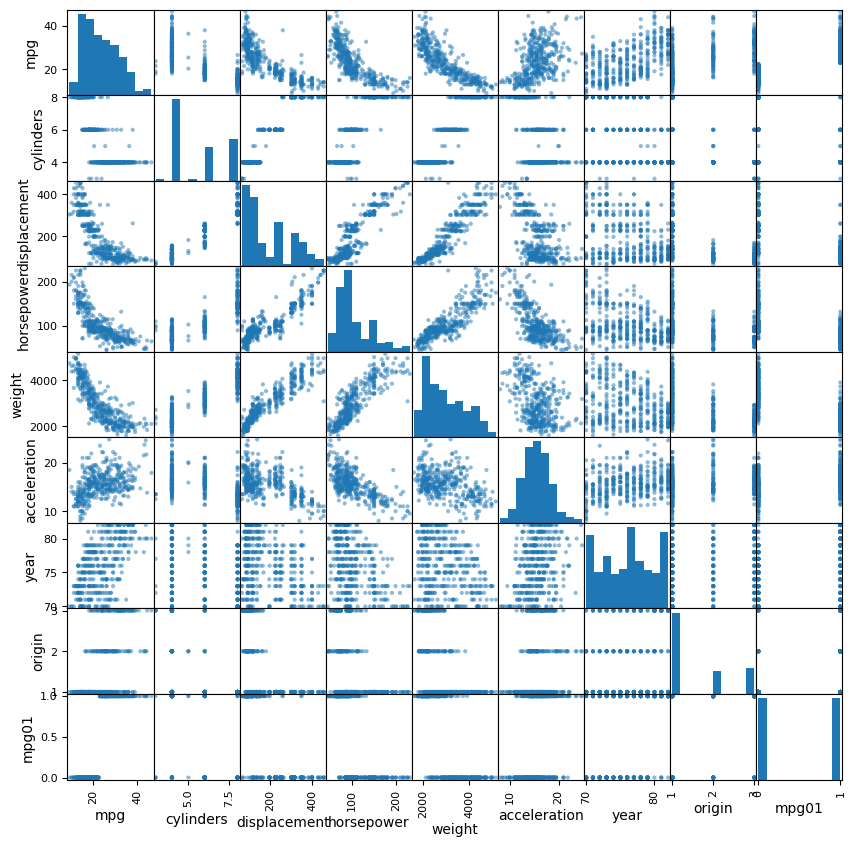

In [162]:
pd.plotting.scatter_matrix(Auto, figsize =(10,10));

In [163]:
Auto.corr(numeric_only = True).round(4).style.background_gradient(cmap = 'coolwarm')

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
mpg,1.000000,-0.777600,-0.805100,-0.778400,-0.832200,0.423300,0.580500,0.565200,0.836900
cylinders,-0.777600,1.000000,0.950800,0.843000,0.897500,-0.504700,-0.345600,-0.568900,-0.759200
displacement,-0.805100,0.950800,1.000000,0.897300,0.933000,-0.543800,-0.369900,-0.614500,-0.753500
horsepower,-0.778400,0.843000,0.897300,1.000000,0.864500,-0.689200,-0.416400,-0.455200,-0.667100
weight,-0.832200,0.897500,0.933000,0.864500,1.000000,-0.416800,-0.309100,-0.585000,-0.757800
acceleration,0.423300,-0.504700,-0.543800,-0.689200,-0.416800,1.000000,0.290300,0.212700,0.346800
year,0.580500,-0.345600,-0.369900,-0.416400,-0.309100,0.290300,1.000000,0.181500,0.429900
origin,0.565200,-0.568900,-0.614500,-0.455200,-0.585000,0.212700,0.181500,1.000000,0.513700
mpg01,0.836900,-0.759200,-0.753500,-0.667100,-0.757800,0.346800,0.429900,0.513700,1.000000


Weight, Cylinders and Acceleration would be good in predicting the mpg01 since the high correlation

In [170]:
X = Auto[["weight", 'displacement', 'cylinders']]
y = Auto.mpg01
(X_train,X_test,y_train,y_test) = train_test_split(X,y,random_state=1)


In [177]:
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)
lda_predict = lda.predict(X_test)
confusion_table(lda_predict, y_test)

Truth,0,1
Predicted,,
0,49,2
1,5,42


In [179]:
np.mean(lda_predict == y_test), np.mean(lda_predict != y_test)

(0.9285714285714286, 0.07142857142857142)

Error is 7.1% 

In [180]:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)
qda_predict = qda.predict(X_test)
confusion_table(qda_predict, y_test)

Truth,0,1
Predicted,,
0,52,4
1,2,40


In [181]:
np.mean(qda_predict != y_test)

0.061224489795918366

Error is 6% 

In [183]:
NB = GaussianNB() 
NB.fit(X_train, y_train)
NB_predict = NB.predict(X_test)
confusion_table(NB_predict, y_test)


Truth,0,1
Predicted,,
0,51,4
1,3,40


In [184]:
np.mean(NB_predict != y_test)

0.07142857142857142

Error is 7.14% 

In [186]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
confusion_table(lr_predict, y_test)

Truth,0,1
Predicted,,
0,50,2
1,4,42


In [187]:
np.mean(lr_predict != y_test)


0.061224489795918366

Error is 6.1% 


In [189]:
Error = []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    knn_predict = knn.predict(X_test)
    Error.append(np.mean(knn_predict != y_test))

Error = pd.DataFrame(Error, columns = ['Test Error'], index = range(1,20))
Error.index.name = 'k'
Error




,Test Error
k,
1,0.153061
2,0.122449
3,0.132653
4,0.122449
5,0.142857
6,0.112245
7,0.122449
8,0.091837
9,0.102041


In [199]:
K_best = Error.iloc[:,0].idxmin()
print(f"Index of minimum value: {K_best}, {Error.loc[K_best]}")

Index of minimum value: 13, Test Error    0.081633
Name: 13, dtype: float64


**Problem 16**


In [211]:
Boston = load_data("Boston")
crim01 = []
for i in range(len(Boston)):
    if Boston.crim.iloc[i] > Boston.crim.median():
        crim01.append(1)
    else:
        crim01.append(0)

Boston['crim01'] = crim01
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv', 'crim01'],
      dtype='object')

In [212]:
Boston.corr(numeric_only = True).round(4).style.background_gradient(cmap = 'coolwarm')

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,crim01
crim,1.000000,-0.200500,0.406600,-0.055900,0.421000,-0.219200,0.352700,-0.379700,0.625500,0.582800,0.289900,0.455600,-0.388300,0.409400
zn,-0.200500,1.000000,-0.533800,-0.042700,-0.516600,0.312000,-0.569500,0.664400,-0.311900,-0.314600,-0.391700,-0.413000,0.360400,-0.436200
indus,0.406600,-0.533800,1.000000,0.062900,0.763700,-0.391700,0.644800,-0.708000,0.595100,0.720800,0.383200,0.603800,-0.483700,0.603300
chas,-0.055900,-0.042700,0.062900,1.000000,0.091200,0.091300,0.086500,-0.099200,-0.007400,-0.035600,-0.121500,-0.053900,0.175300,0.070100
nox,0.421000,-0.516600,0.763700,0.091200,1.000000,-0.302200,0.731500,-0.769200,0.611400,0.668000,0.188900,0.590900,-0.427300,0.723200
rm,-0.219200,0.312000,-0.391700,0.091300,-0.302200,1.000000,-0.240300,0.205200,-0.209800,-0.292000,-0.355500,-0.613800,0.695400,-0.156400
age,0.352700,-0.569500,0.644800,0.086500,0.731500,-0.240300,1.000000,-0.747900,0.456000,0.506500,0.261500,0.602300,-0.377000,0.613900
dis,-0.379700,0.664400,-0.708000,-0.099200,-0.769200,0.205200,-0.747900,1.000000,-0.494600,-0.534400,-0.232500,-0.497000,0.249900,-0.616300
rad,0.625500,-0.311900,0.595100,-0.007400,0.611400,-0.209800,0.456000,-0.494600,1.000000,0.910200,0.464700,0.488700,-0.381600,0.619800
tax,0.582800,-0.314600,0.720800,-0.035600,0.668000,-0.292000,0.506500,-0.534400,0.910200,1.000000,0.460900,0.544000,-0.468500,0.608700


Best correlations would be nox, rad and dis.

In [ ]:
X = Boston[["nox", 'rad', 'dis']]
y = Boston.crim01
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 1)

Models = ["LR", 
          'LDA', 
          'NB', 
          'KNN5']

Test_Accuracy = []


Logisitic Regression

In [229]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
Test_Accuracy.append(np.mean(lr_predict == y_test))
confusion_table(lr_predict, y_test)


Truth,0,1
Predicted,,
0,47,11
1,13,56


LDA

In [230]:
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)
lda_predict = lda.predict(X_test)
Test_Accuracy.append(np.mean(lda_predict == y_test))
confusion_table(lda_predict, y_test)


Truth,0,1
Predicted,,
0,57,18
1,3,49


Naive Bayes 

In [231]:
NB = GaussianNB() 
NB.fit(X_train, y_train)
NB_predict = NB.predict(X_test)
Test_Accuracy.append(np.mean(NB_predict == y_test))
confusion_table(NB_predict, y_test)

Truth,0,1
Predicted,,
0,55,14
1,5,53


KNN (n = 5)

In [232]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)
Test_Accuracy.append(np.mean(knn_predict == y_test))
confusion_table(knn_predict, y_test)

Truth,0,1
Predicted,,
0,54,10
1,6,57


In [233]:
pd.DataFrame({"Test Accuracy": Test_Accuracy}, index = Models)

,Test Accuracy
LR,0.811024
LDA,0.834646
NB,0.850394
KNN5,0.874016
